# Enhanced Skin Cancer Detection Using Diffusion-Based Data Augmentation and Vision Transformers

# Installing Libraries

In [ ]:
# %pip uninstall -y torch torchvision
# %pip install torch==2.5.0 torchvision==0.20.0
# %pip install evaluate
# %pip install wandb
# %pip install huggingface_hub
# %pip install torch==2.5.0 torchvision==0.20.0 --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121
     ---------------------------------------- 0.0/2.4 GB ? eta -:--:--
     ---------------------------------------- 0.0/2.4 GB 19.8 MB/s eta 0:02:04
     ---------------------------------------- 0.0/2.4 GB 20.0 MB/s eta 0:02:03
     ---------------------------------------- 0.0/2.4 GB 19.8 MB/s eta 0:02:04
     ---------------------------------------- 0.0/2.4 GB 21.5 MB/s eta 0:01:54
     ---------------------------------------- 0.0/2.4 GB 20.1 MB/s eta 0:02:02
     ---------------------------------------- 0.0/2.4 GB 22.4 MB/s eta 0:01:50
     ---------------------------------------- 0.0/2.4 GB 22.1 MB/s eta 0:01:51
     ---------------------------------------- 0.0/2.4 GB 22.7 MB/s eta 0:01:48
     ---------------------------------------- 0.0/2.4 GB 23.8 MB/s eta 0:01:43
     ---------------------------------------- 0.0/2.4 GB 23.2 MB/s eta 0:01:46
     ---------------------------------------- 0.0/2.4 GB 23.2 MB/s eta 0:01:46
 


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import pandas as pd
import os
import numpy as np
from PIL import Image

import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from transformers import AutoImageProcessor, AutoModelForImageClassification, Trainer, TrainingArguments

import wandb


c:\Users\win10\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Preprocessing

### Load Training and Testing Data

In [3]:
def process_dataset(csv_file, image_dir, label_map):
    labels_df = pd.read_csv(csv_file, header=None, names=['image_id', 'label'])
    labels_df['label'] = labels_df['label'].map(label_map)
    labels_df['file_path'] = labels_df['image_id'].apply(lambda x: os.path.join(image_dir, f"{x}.jpg"))
    
    return labels_df

label_map_train = {'benign': 0, 'malignant': 1}
label_map_test = {0.0: 0, 1.0: 1}

train_csv_file = 'datasets/ISIC2016/ISBI2016_ISIC_Part3_Training_GroundTruth.csv'
train_image_dir = 'datasets/ISIC2016/ISBI2016_ISIC_Part1_Training_Data'

test_csv_file = 'datasets/ISIC2016/ISBI2016_ISIC_Part3_Test_GroundTruth.csv'
test_image_dir = 'datasets/ISIC2016/ISBI2016_ISIC_Part1_Test_Data'

train_labels_df = process_dataset(train_csv_file, train_image_dir, label_map_train)
test_labels_df = process_dataset(test_csv_file, test_image_dir, label_map_test)
validation_labels_df, test_labels_df = train_test_split(test_labels_df, test_size=0.5, random_state=42)

print(train_labels_df.head())
print(test_labels_df.head())
print(validation_labels_df.head())

       image_id  label                                          file_path
0  ISIC_0000000      0  datasets/ISIC2016/ISBI2016_ISIC_Part1_Training...
1  ISIC_0000001      0  datasets/ISIC2016/ISBI2016_ISIC_Part1_Training...
2  ISIC_0000002      1  datasets/ISIC2016/ISBI2016_ISIC_Part1_Training...
3  ISIC_0000004      1  datasets/ISIC2016/ISBI2016_ISIC_Part1_Training...
4  ISIC_0000006      0  datasets/ISIC2016/ISBI2016_ISIC_Part1_Training...
         image_id  label                                          file_path
288  ISIC_0010451      0  datasets/ISIC2016/ISBI2016_ISIC_Part1_Test_Dat...
283  ISIC_0010379      1  datasets/ISIC2016/ISBI2016_ISIC_Part1_Test_Dat...
327  ISIC_0011092      0  datasets/ISIC2016/ISBI2016_ISIC_Part1_Test_Dat...
145  ISIC_0001685      0  datasets/ISIC2016/ISBI2016_ISIC_Part1_Test_Dat...
55   ISIC_0000202      0  datasets/ISIC2016/ISBI2016_ISIC_Part1_Test_Dat...
         image_id  label                                          file_path
11   ISIC_0000040      1

### Dataset Characterization and Visualization

Train
Dataset has 2 classes and 900 samples.
Class counts:
0    727
1    173
Name: label, dtype: int64


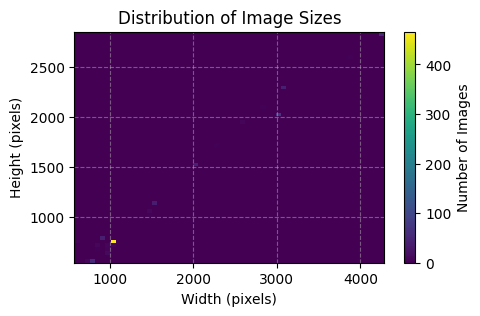

Validation
Dataset has 2 classes and 189 samples.
Class counts:
0    152
1     37
Name: label, dtype: int64


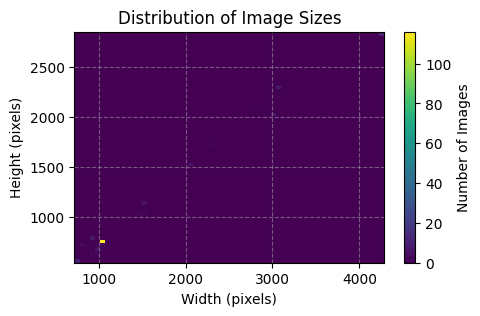

Test
Dataset has 2 classes and 190 samples.
Class counts:
0    152
1     38
Name: label, dtype: int64


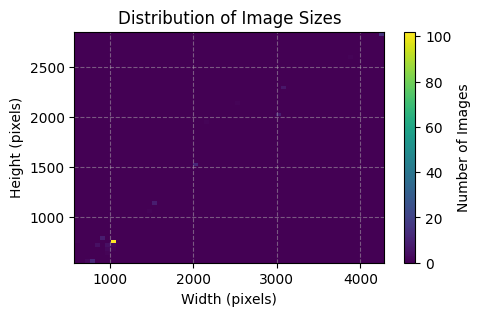

In [4]:
def characterize_dataset(labels_df):
        widths, heights = [], []
        class_counts = labels_df['label'].value_counts()
        
        for idx, row in labels_df.iterrows():
            image = Image.open(row['file_path'])
            widths.append(image.size[0])
            heights.append(image.size[1])
        
        print(f"Dataset has {len(class_counts)} classes and {len(labels_df)} samples.")
        print(f"Class counts:\n{class_counts}")
       
        plt.figure(figsize=(5, 3))
        plt.hist2d(widths, heights, bins=60, cmap='viridis')
        plt.colorbar(label='Number of Images')
        plt.title("Distribution of Image Sizes")
        plt.xlabel("Width (pixels)")
        plt.ylabel("Height (pixels)")
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.show()

print("Train")
characterize_dataset(train_labels_df)
print("Validation")
characterize_dataset(validation_labels_df)
print("Test")
characterize_dataset(test_labels_df)

### Plotting Samples


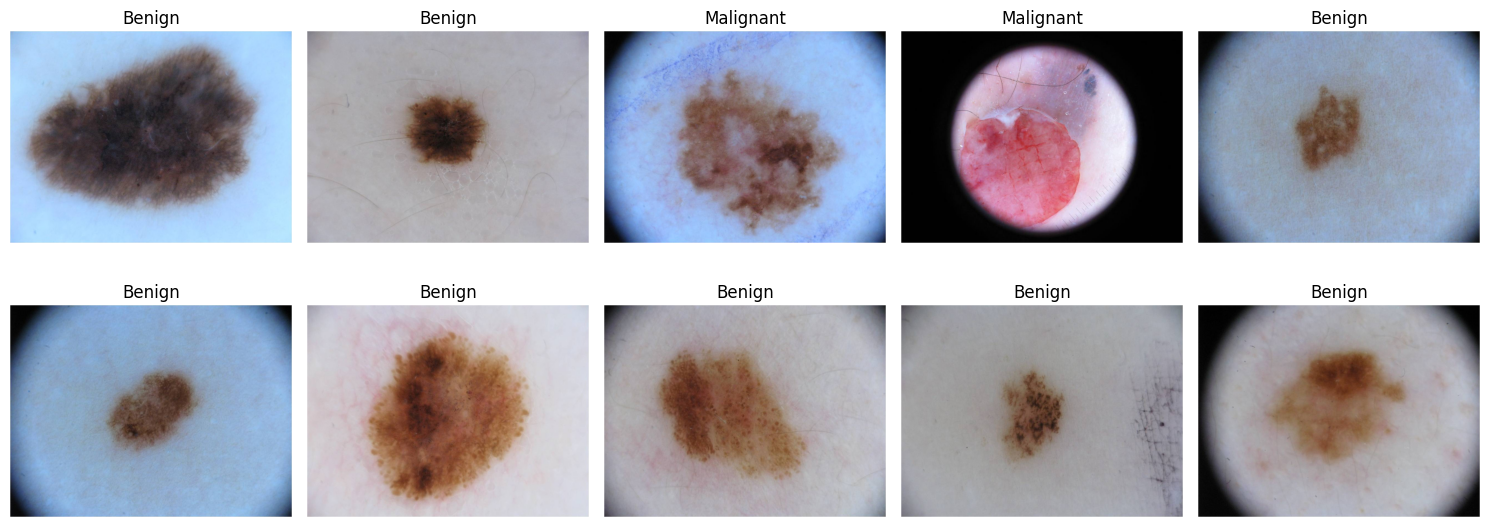

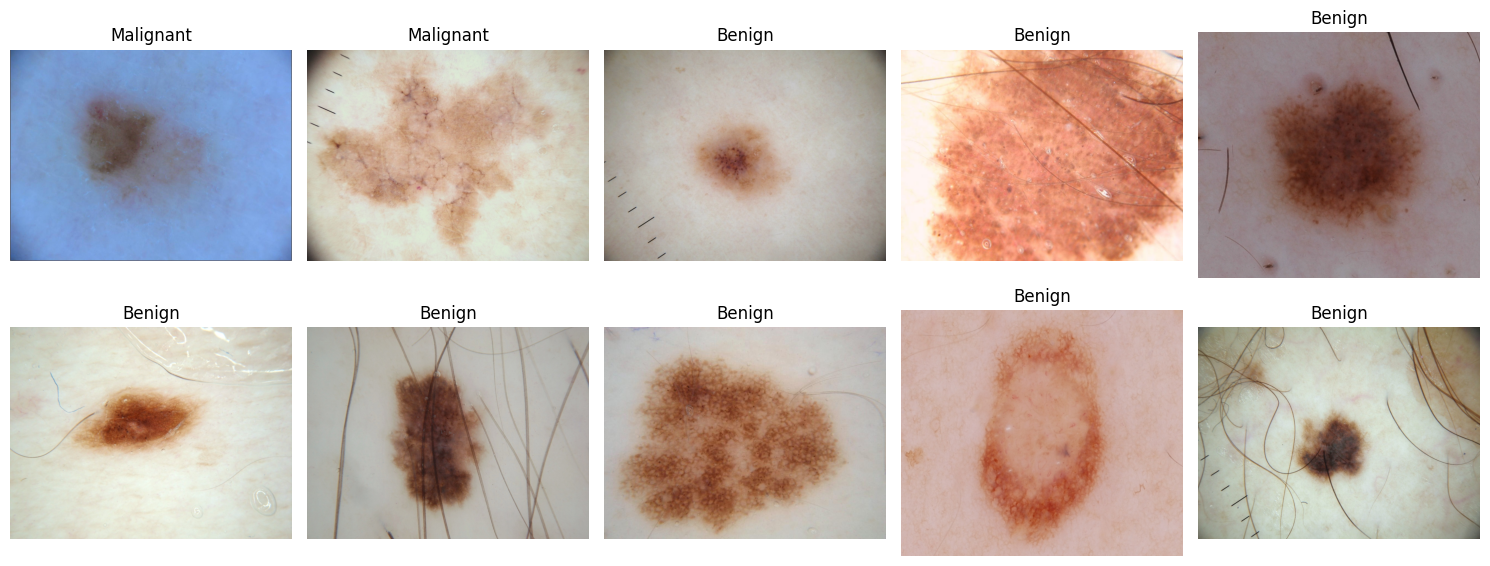

In [ ]:
def plot_samples(labels_df, rows=2, cols=5, processor=None):
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    axes = axes.flatten()
    
    for i in range(rows * cols):
        row = labels_df.iloc[i]
        image_path = row['file_path']
        label = row['label']
        
        image = Image.open(image_path).convert("RGB")
        
        if processor:
            image = processor(images=image, return_tensors="pt")['pixel_values'].squeeze(0).permute(1, 2, 0).numpy()
        else:
            image = np.array(image)

        axes[i].imshow(image)
        axes[i].set_title('Malignant' if label == 1 else 'Benign')  # Set title based on the label
        axes[i].axis('off')  # Turn off axes
    plt.tight_layout()
    plt.show()

plot_samples(train_labels_df)
plot_samples(validation_labels_df)

# Classification using Vision Transformers

### Defining Dataset for ViT

In [6]:
class ISICDatasetTransform(Dataset):
    def __init__(self, labels_df, processor=None):
        self.labels_df = labels_df
        self.processor = processor

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        row = self.labels_df.iloc[idx]
        image = Image.open(row['file_path']).convert("RGB")
        inputs = self.processor(images=image, return_tensors="pt")
        label = row['label']
        inputs['labels'] = torch.tensor(label)
        
        return inputs

### Loading Model and Processor

In [7]:
def load_model_and_processor(model_name):
    processor = AutoImageProcessor.from_pretrained(model_name)
    model = AutoModelForImageClassification.from_pretrained(
        model_name,
        num_labels=2,
        ignore_mismatched_sizes = True
    )
    for name,p in model.named_parameters():
        if not name.startswith('classifier'):
            p.requires_grad = False

    num_params = sum([p.numel() for p in model.parameters()])
    trainable_params = sum([p.numel() for p in model.parameters() if p.requires_grad])

    print(f"{num_params = :,} | {trainable_params = :,}")

    return model, processor

### Data Collator Function

In [8]:
def collate_fn(batch):
    pixel_values = torch.stack([x['pixel_values'].squeeze(0) for x in batch])
    labels = torch.tensor([x['labels'] for x in batch])
    
    # # Check the shape of the batch
    # print(f"Shape of pixel_values batch: {pixel_values.shape}")
    # print(f"Shape of labels batch: {labels.shape}")
    
    return {
        'pixel_values': pixel_values,
        'labels': labels
    }

### Metric Computation for Evaluation

In [9]:
from sklearn.metrics import recall_score, confusion_matrix, average_precision_score, roc_auc_score, accuracy_score

def compute_metrics(eval_preds):
    logits, labels = eval_preds
    logits = torch.tensor(logits)
    predictions = torch.argmax(logits, axis=1).numpy()  # Get predicted classes
    probabilities = torch.softmax(logits, dim=1)[:, 1].numpy()  # Probabilities for class 1

    # Accuracy
    accuracy_score_value = accuracy_score(labels, predictions)
    
    # Sensitivity (Recall for positive class)
    sensitivity_score = recall_score(labels, predictions, pos_label=1)
    
    # Specificity
    tn, fp, fn, tp = confusion_matrix(labels, predictions).ravel()
    specificity_score = tn / (tn + fp)
    
    # Average Precision
    avg_precision = average_precision_score(labels, probabilities)
    
    # AUC-ROC
    auc_score = roc_auc_score(labels, probabilities)

    wandb.log({
        'accuracy': accuracy_score_value,
        'sensitivity': sensitivity_score,
        'specificity': specificity_score,
        'average_precision': avg_precision,
        'auc_roc': auc_score
    })
    
    return {
        'accuracy': accuracy_score_value,
        'sensitivity': sensitivity_score,
        'specificity': specificity_score,
        'average_precision': avg_precision,
        'auc_roc': auc_score
    }

## Model Training and Evaluation

In [16]:
wandb.init(project='skin_cancer_detection')
model_names = ["google/vit-base-patch16-224"]

import json
output_file = './output/model_comparison.json'
try:
    with open(output_file, 'r') as f:
        results = json.load(f)
except FileNotFoundError:
    results = {}

for model_name in model_names:
    # Load model and processor
    model, processor = load_model_and_processor(model_name)
    
    # Prepare dataset with processor's transformations
    train_dataset = ISICDatasetTransform(train_labels_df, processor)
    eval_dataset = ISICDatasetTransform(validation_labels_df, processor)
    test_dataset = ISICDatasetTransform(test_labels_df, processor)

    # Define Training Arguments
    training_args = TrainingArguments(
        output_dir=f'./results/{model_name}',
        per_device_train_batch_size=16,
        eval_strategy="epoch",
        save_strategy="epoch",
        logging_steps=100,
        num_train_epochs=3,
        learning_rate=1e-4,
        save_total_limit=1,
        remove_unused_columns=False,
        push_to_hub=True,
        report_to='wandb',
        load_best_model_at_end=True,
    )

    # Define Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        data_collator=collate_fn,
        compute_metrics=compute_metrics,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        tokenizer=processor,
    )

    # Train and evaluate
    print(f"Training and evaluating model: {model_name}")
    trainer.train(resume_from_checkpoint=True)
    eval_results = trainer.evaluate(test_dataset)
    results[model_name] = eval_results

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\win10\AppData\Local\Temp\ipykernel_20448\4066118612.py:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


num_params = 85,800,194 | trainable_params = 1,538
Training and evaluating model: google/vit-base-patch16-224


c:\Users\win10\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\trainer.py:3354: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(

{'train_runtime': 0.0945, 'train_samples_per_second': 28582.514, 'train_steps_per_second': 1810.226, 'train_loss': 0.0, 'epoch': 3.0}


100%|██████████| 24/24 [00:34<00:00,  1.42s/it]


In [17]:
wandb.finish()

accuracy,▁
auc_roc,▁
average_precision,▁
eval/accuracy,▁
eval/auc_roc,▁
eval/average_precision,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/sensitivity,▁
eval/specificity,▁


### Results for Comparison

In [18]:
# Print out the results for comparison
for model_name, metrics in results.items():
    print(f"Model: {model_name}")
    for metric_name, metric_value in metrics.items():
        print(f"  {metric_name}: {metric_value:.4f}")
    print("\n")


# Save the results in JSON format
with open(output_file, 'w') as f:
    json.dump(results, f, indent=4)

print(f"Results saved to {output_file}")

Model: google/vit-base-patch16-224
  eval_loss: 0.4791
  eval_accuracy: 0.8000
  eval_sensitivity: 0.0000
  eval_specificity: 1.0000
  eval_average_precision: 0.3659
  eval_auc_roc: 0.6440
  eval_runtime: 35.8723
  eval_samples_per_second: 5.2970
  eval_steps_per_second: 0.6690
  epoch: 3.0000


Results saved to ./output/model_comparison.json
